In [278]:
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))

In [279]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np 
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor
from parametric_pushforward.visualization import path_visualization_snapshots, path_visualization_with_trajectories,display_bds,create_particle_animation
from parametric_pushforward.spline import Assemble_spline
from parametric_pushforward.obstacles import obstacle_cost_stunnel, obstacle_cost_vneck, obstacle_cost_gmm,congestion_cost,geodesic
from parametric_pushforward.opinion import PolarizeDyn
from parametric_pushforward.setup_density_path_problem import load_boundary_models,get_activation,opinion_dynamics_setup,get_potential_functions

from geomloss import SamplesLoss

sinkhorn = SamplesLoss(loss = 'sinkhorn', p = 2, blur = 0.05)

import os
import yaml


In [280]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [281]:
# name of experiment
exp_dir = str(root_path)+ '/experiments/8gaussiansv3_to_4gaussians_pot_obstacle_cost_gmm_20250430_133618'
yaml_path = os.path.join(exp_dir, 'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [282]:

name_data0 = config['data']['source']['name']
checkpt0 = 'final'#'checkpoint_1999'
name_data1 = config['data']['target']['name']
checkpt1 = 'final'#'checkpoint_1999'

arch_dims = [config['architecture']['input_dim'],config['architecture']['hidden_dim'],config['architecture']['num_layers']]
activation = get_activation(config['architecture']['activation'])

arch = arch_dims+[activation]

spline_type = config['spline']['type']


prior = MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))

state0,state1 = load_boundary_models(config,device)
theta0 = order_state_to_tensor(state0)
theta1 = order_state_to_tensor(state1)

if config.get('opinion_dynamics',{}).get('active',False):
    print('Opinion dynamics active')
    opinion_dynamics = opinion_dynamics_setup(config)
    ke_modifier = [PolarizeDyn(opinion_dynamics).to(device)]
else:
    ke_modifier = None


In [283]:
# Build spline
num_collocation = config['spline']['num_collocation']
spline0,t = Assemble_spline(theta0=theta0,
                            theta1=theta1,
                            arch=arch,
                            data0=name_data0,
                            data1=name_data1,
                            ke_modifier=ke_modifier,
                            potential=get_potential_functions(config['potential_functions']),
                            number_of_knots=num_collocation,
                            spline=spline_type,
                            device = device,
                            prior_dist=prior)

spline0.sigma = config['coefficients_potentials']['sigma']


In [284]:

spline_path = os.path.join(exp_dir, 'checkpoints/spline.pth') #geo_initial / initial / spline
try:
    state_spline0 = torch.load(spline_path,map_location=device)#['ema_model']
    spline0.load_state_dict(state_spline0)
except:
    state_spline0 = torch.load(spline_path,map_location=device)['ema_model'] #direct_model #ema_model
    spline0.load_state_dict(state_spline0)
    

spline0.eval()
spline0.sigma

0

In [285]:
samples_per_gaussian = 1000
t_node = 10
x0 = torch.from_numpy(toy_data.inf_train_gen(name_data0, batch_size=samples_per_gaussian,dim = config['architecture']['input_dim'])).float().to(device)
x1 = torch.from_numpy(toy_data.inf_train_gen(name_data1, batch_size=samples_per_gaussian,dim = config['architecture']['input_dim'])).float().to(device)
# Evaluate modle
z = spline0.prior_dist.sample((samples_per_gaussian,))
x0_aprox = spline0.push_forward(spline0.x0.flatten(),z)
x1_aprox = spline0.push_forward(spline0.x1.flatten(),z)
# Obtain distances
print('Sinkhorn distance to source density: {}'.format(sinkhorn(x0,x0_aprox)))
print('Sinkhorn distance to target density: {}'.format(sinkhorn(x1,x1_aprox)))


# Get z values by flowing backwards
z0 = spline0.pull_back(spline0.x0.flatten(),x0)
y0 = spline0.push_forward(spline0.x1.flatten(),z0)


z0 = spline0.prior_dist.sample((samples_per_gaussian,)).to(device)
z1 = z0.clone()

Sinkhorn distance to source density: 0.6991140246391296
Sinkhorn distance to target density: 0.03858134150505066


/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


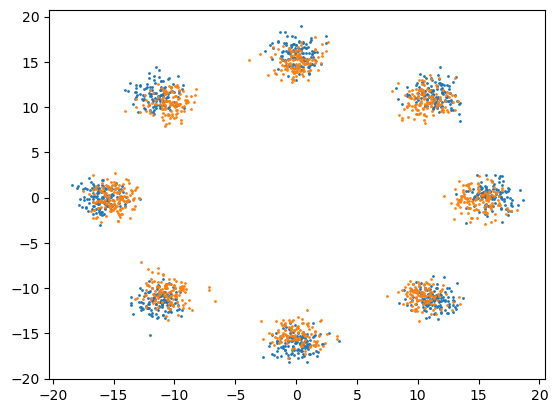

In [286]:
plt.scatter(x0.cpu().detach().numpy()[:,0],x0.cpu().detach().numpy()[:,1],s=1)
plt.scatter(x0_aprox.cpu().detach().numpy()[:,0],x0_aprox.cpu().detach().numpy()[:,1],s=1)

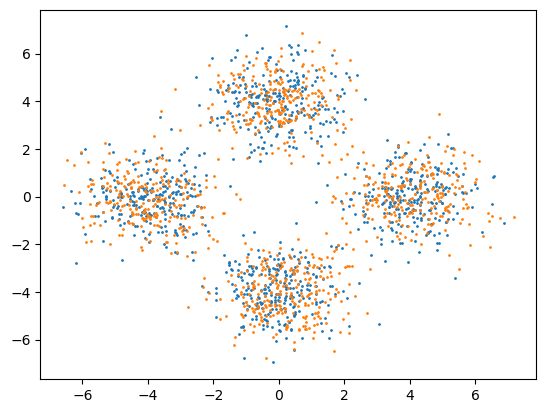

In [287]:
plt.scatter(x1.cpu().detach().numpy()[:,0],x1.cpu().detach().numpy()[:,1],s=1)
plt.scatter(x1_aprox.cpu().detach().numpy()[:,0],x1_aprox.cpu().detach().numpy()[:,1],s=1)

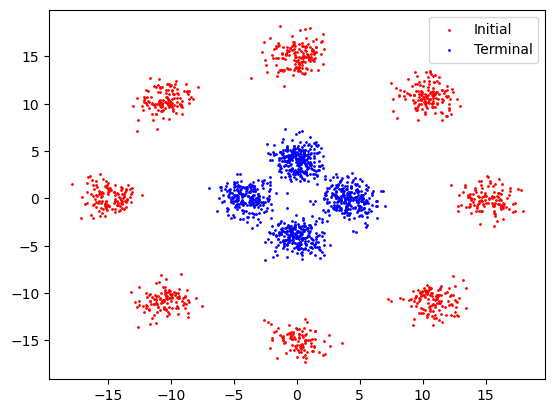

In [288]:
display_bds(spline0,device = device)

Text(0.5, 1.0, 'Induced coupling')

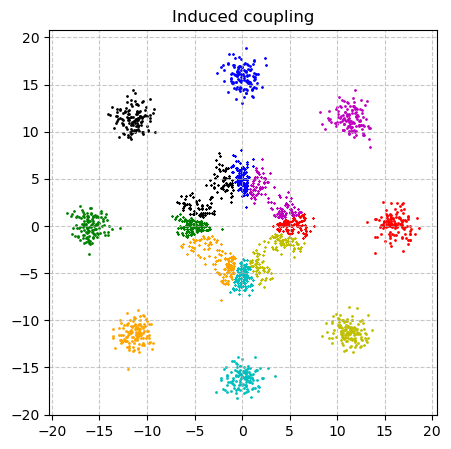

In [289]:
# For checkboard or 8gmm coupling visualization

colors = ['r','g','b','c','m','y','k','orange']#
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.grid(True,linestyle = '--',alpha = 0.7)
for i in range(8):
    plt.scatter(x0[i*samples_per_gaussian//8:(i+1)*samples_per_gaussian//8,0].cpu().detach().numpy(),x0[i*samples_per_gaussian//8:(i+1)*samples_per_gaussian//8,1].cpu().detach().numpy(),color=colors[i],s = 1)
    plt.scatter(y0[i*samples_per_gaussian//8:(i+1)*samples_per_gaussian//8,0].cpu().detach().numpy(),y0[i*samples_per_gaussian//8:(i+1)*samples_per_gaussian//8,1].cpu().detach().numpy(),color=colors[i],marker='x', s = 1)

plt.title('Induced coupling')

In [290]:
# # Enhanced basic coupling visualization
# plt.figure(figsize=(12, 10))

# # Add a light grid
# plt.grid(True, linestyle='--', alpha=0.7)

# # Plot with improved markers and add connecting lines
# for i in range(8):
#     source_points = x0[i*samples_per_gaussian:(i+1)*samples_per_gaussian]
#     target_points = y0[i*samples_per_gaussian:(i+1)*samples_per_gaussian]
    
#     # Plot points with better visibility
#     plt.scatter(source_points[:,0].cpu().detach().numpy(), 
#                 source_points[:,1].cpu().detach().numpy(),
#                 color=colors[i], alpha=0.7, s=50, edgecolors='black', linewidths=0.5)
    
#     plt.scatter(target_points[:,0].cpu().detach().numpy(), 
#                 target_points[:,1].cpu().detach().numpy(),
#                 color=colors[i], alpha=0.7, marker='x', s=50, linewidths=1.5)
    
#     # Add connecting lines for a subset of points to avoid overcrowding
#     for j in range(min(10, samples_per_gaussian)):
#         plt.plot([source_points[j,0].item(), target_points[j,0].item()],
#                  [source_points[j,1].item(), target_points[j,1].item()],
#                  color=colors[i], alpha=0.3, linewidth=0.5)

# # Create a more informative legend
# legend_elements = []
# for i in range(8):
#     legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
#                           markerfacecolor=colors[i], markersize=10, 
#                           label=f'Source Component {i+1}'))
#     legend_elements.append(plt.Line2D([0], [0], marker='x', color=colors[i],
#                           markersize=10, linewidth=0, 
#                           label=f'Target Component {i+1}'))

# plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# # Add informative labels and title
# plt.title('Optimal Transport Coupling Between Gaussian Mixtures', fontsize=16)
# plt.xlabel('X Coordinate', fontsize=12)
# plt.ylabel('Y Coordinate', fontsize=12)

# # Add explanatory text
# plt.figtext(0.5, 0.01, 
#            'Each color represents a different Gaussian component.\n'
#            'Lines show how mass is transported from source (circles) to target (crosses).',
#            ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# plt.tight_layout()

In [291]:
# Path plot

s = torch.linspace(0,1,40).to(device)

Number of interpolation points: 5


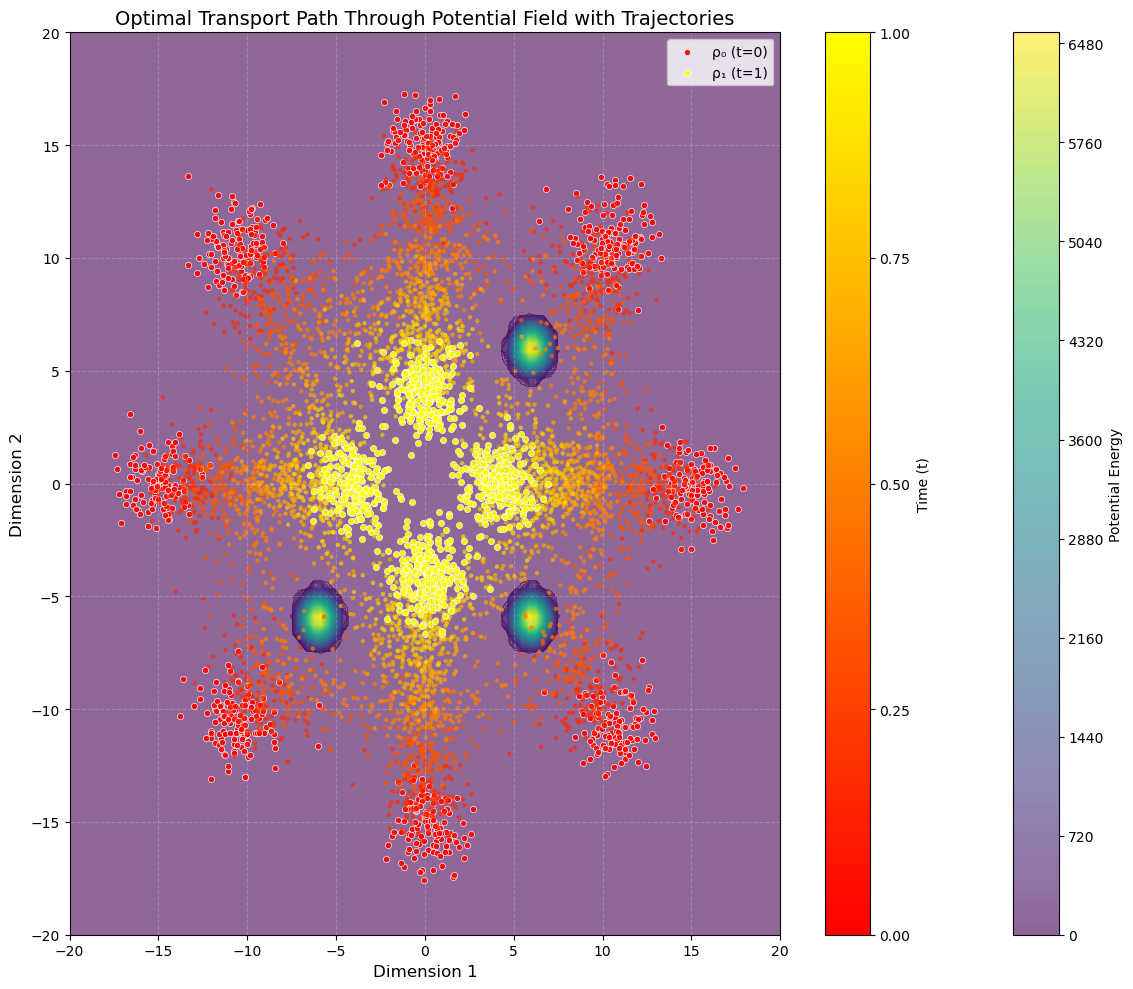

In [292]:

interpolation0 = spline0(t)
print('Number of interpolation points:',len(t)-2)
samples_path0 = path_visualization_with_trajectories(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],
num_samples = 50,
time_steps = 10,solver = 'midpoint',
z = z0,num_contour_points = 100)

/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


/work/Sebas/Density_Path_Opt/Parametric_pushforward/parametric_pushforward/visualization.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 0.9, 0.95])


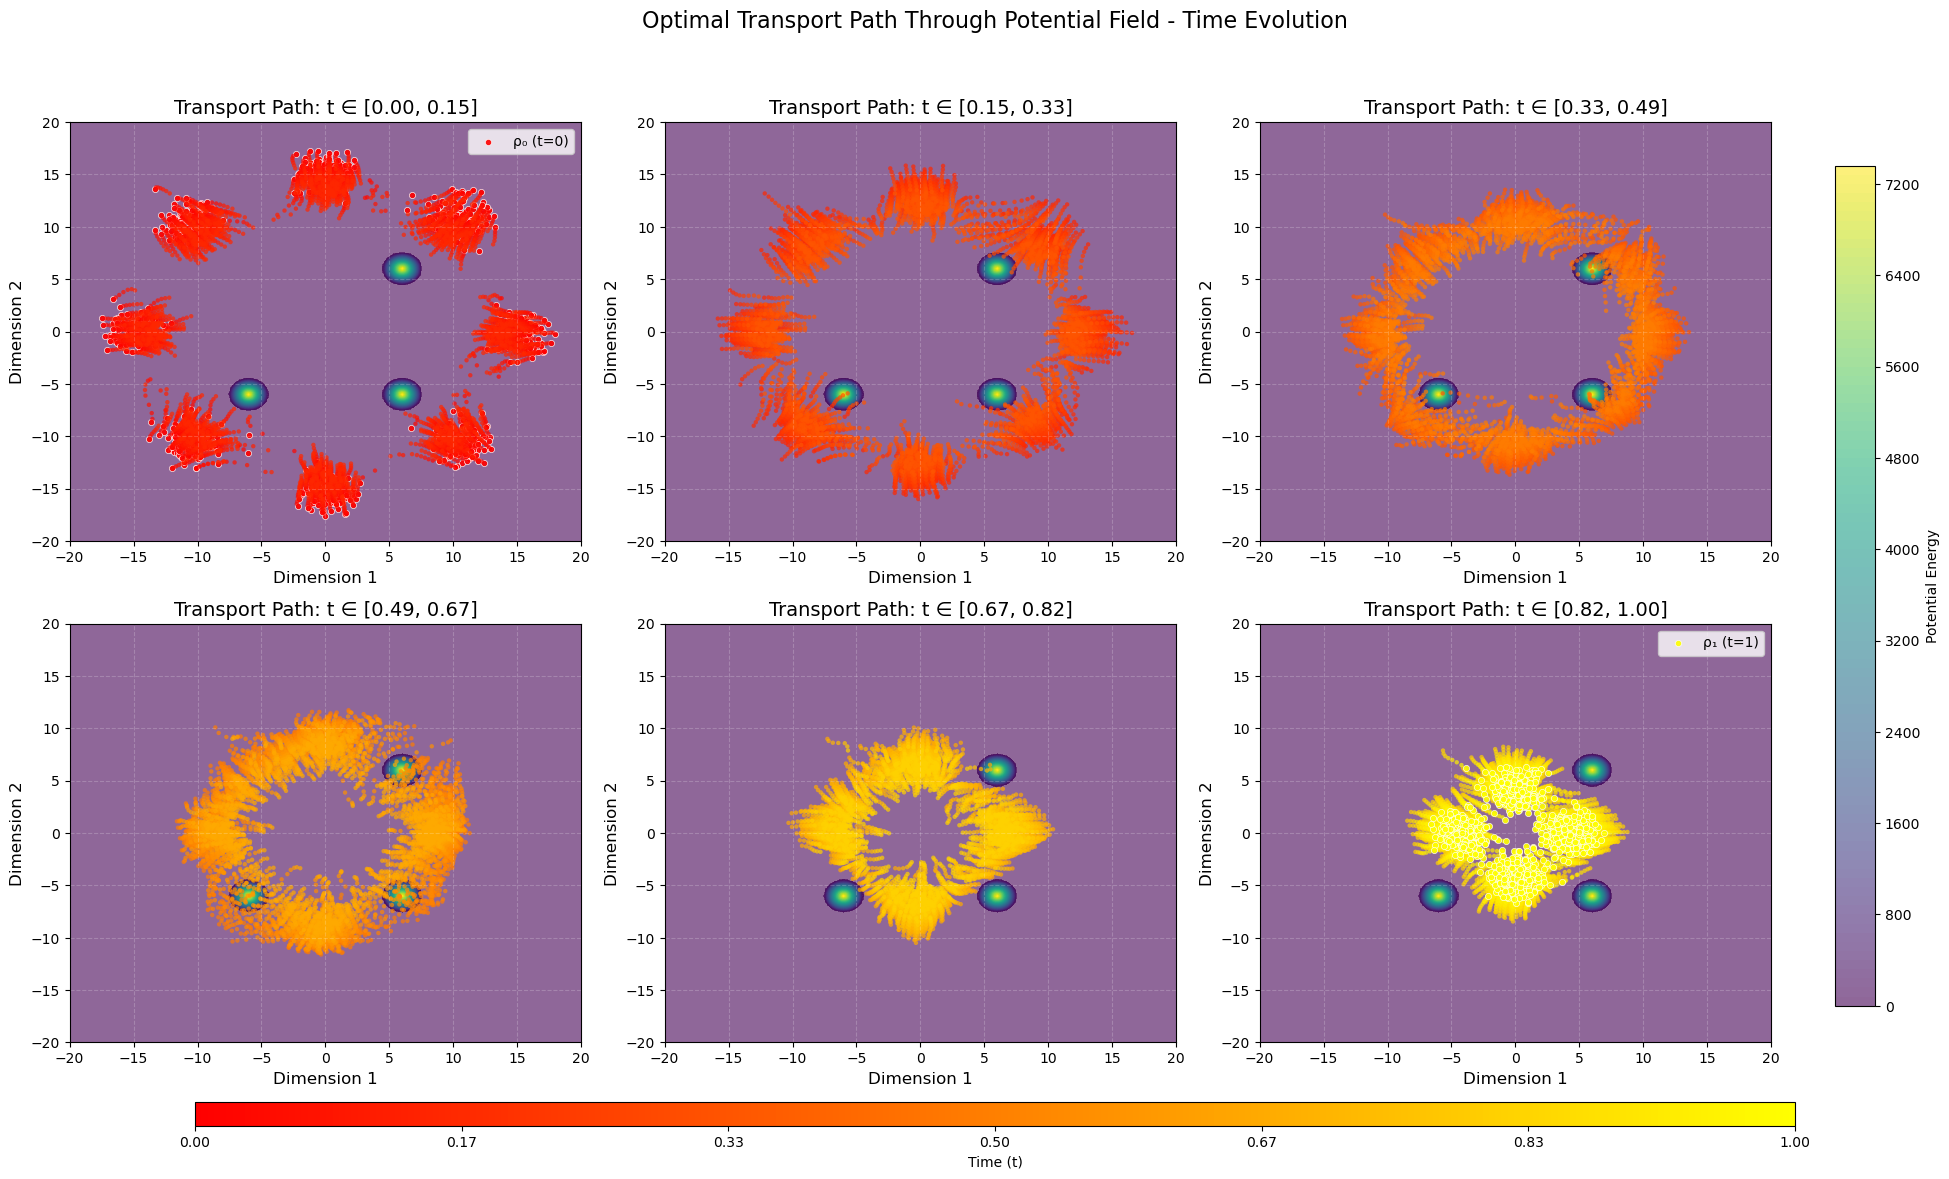

In [293]:
interpolation0 = spline0(s)
samples_path0 = path_visualization_snapshots(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],

num_samples = 50,
time_steps = 10,solver = 'midpoint',
z = z0,num_contour_points = 250)

In [294]:
animation = create_particle_animation(spline0,samples_path0.detach().cpu().permute(1,0,2),x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],interval=250)
display(animation)

In [295]:
if spline0.fisher_pot and not spline0.entropy_pot:
    norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    entropy = None
elif spline0.entropy_pot and not spline0.fisher_pot:
    entropy,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    norm_score0 = None
elif spline0.entropy_pot and spline0.fisher_pot:
    entropy,norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
else:
    entropy = None
    norm_socre0 = None

lagrangian0,ke,pe = spline0.lagrangian(samples_path0.to(device),s,log_density= entropy,score=norm_socre0)

print(lagrangian0,ke,pe)

tensor(95.4572, device='cuda:0') tensor(80.5918, device='cuda:0') tensor(14.8654, device='cuda:0')


In [296]:
lagrangian0-norm_socre0.mean()

AttributeError: 'NoneType' object has no attribute 'mean'